In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.distributions as dist
from torch.autograd import Variable
import torch.optim as optim
import random
import math
import numpy
from numpy import linalg as LA
from gcn import GraphLinearLayer, GraphPool, Graph, train
import matplotlib
matplotlib.use("agg")
import matplotlib.pyplot as plt
import time
import matplotlib.cm as cm
%matplotlib inline

In [2]:
def generate_train():
    data = []
    labels = []
    for i in range(100):
        for c in range(2):
            x = torch.rand(6,3)/3. + 1./3.
            if c:
                x[i%2 + 1] = torch.rand(3)/3.
            else:
                x[i%2 + 1] = torch.rand(3)/3. + 2./3.
            data.append(x)
            labels.append(c)
    return data, labels

def generate_test():
    data = []
    labels = []
    for i in range(50):
        for c in range(2):
            x = torch.rand(6,3)/3. + 1./3.
            if c:
                x[4] = torch.rand(3)/3.
            else:
                x[4] = torch.rand(3)/3. + 2./3.
            data.append(x)
            labels.append(c)
    return data, labels

In [3]:
train_data, train_labels = generate_train()
test_data, test_labels = generate_test()

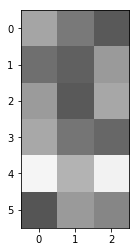

In [4]:
plt.imshow(test_data[38].numpy(),cmap = cm.gray,vmin=0,vmax=1)
plt.show()

In [14]:
def train(data, y, net):
    print(torch.cuda.is_available())
    start = time.time()
    y = torch.FloatTensor([y])
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(net.parameters(), lr=1e-4)
    data = torch.cat(data, 0).view(len(data), -1)
    x = data.cuda()
    y = y.view(-1, 1)
    y = y.cuda()
    print(x.size())
    losses = []
    THRESHHOLD= 1E-6
    
    for epoch in range(30000):
        
        total_loss = 0
        optimizer.zero_grad()
        
        outputs = net(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.data.item()
        if (epoch + 1)%200 == 0:
            print(total_loss)
            losses.append(total_loss)
            if total_loss < THRESHHOLD:
                print("FINISHED TRAINING")
                print("Total number of epochs = ", epoch+1)
                print("Total time = ", time.time() - start)
                break
    return losses

In [15]:
#net 1 - shallow, linear, fully connected
class ShallowFCN(nn.Module):
    
    def __init__(self):
        super(ShallowFCN, self).__init__()
        self.layer0 = nn.Linear(18,18)
        self.layer1 = nn.Linear(18,1)

    def forward(self, x):
        x = x.view(-1, 18)
        x = self.layer1(self.layer0(x))
        return x

In [16]:
#net 2 - shallow, linear, convolutional
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer0 = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1)
        self.layer1 = nn.Linear(18,1)
        
    def forward(self, x):
        x = x.view(-1, 1, 6, 3)
        x = self.layer0(x)
        x = x.view(-1, 18)
        x = self.layer1(x)
        return x

In [17]:
fcn = ShallowFCN()
if torch.cuda.is_available():
    fcn.cuda()
loss_fcn = train(train_data, train_labels, fcn)
fcn.eval()

True
torch.Size([200, 18])
0.6571270823478699
0.6212509870529175
0.5794853568077087
0.5312608480453491
0.4782329499721527
0.4233587682247162
0.36972665786743164
0.3197104036808014
0.27472907304763794
0.23530565202236176
0.20132741332054138
0.17233677208423615
0.1477389931678772
0.12692128121852875
0.10931152105331421
0.09440241008996964
0.08175704628229141
0.07100578397512436
0.06183905526995659
0.05399942770600319
0.0472734235227108
0.041484326124191284
0.036485832184553146
0.03215665742754936
0.028396090492606163
0.025120241567492485
0.022259030491113663
0.01975373551249504
0.01755494996905327
0.015620970167219639
0.01391645148396492
0.012411355972290039
0.011080027557909489
0.009900514036417007
0.00885393749922514
0.007924046367406845
0.007096774410456419
0.00635994877666235
0.005702960770577192
0.005116584710776806
0.0045927525497972965
0.004124410916119814
0.003705334383994341
0.0033300966024398804
0.002993876812979579
0.002692447742447257
0.0024220661725848913
0.00217940006405115

ShallowFCN(
  (layer0): Linear(in_features=18, out_features=18, bias=True)
  (layer1): Linear(in_features=18, out_features=1, bias=True)
)

In [18]:
cnn = CNN()
if torch.cuda.is_available():
    cnn.cuda()
loss_cnn = train(train_data, train_labels, cnn)
cnn.eval()

True
torch.Size([200, 18])
0.6861855983734131
0.6764096617698669
0.6649976372718811
0.6503915786743164
0.6320778727531433
0.610733687877655
0.5871680378913879
0.5619884133338928
0.5356892943382263
0.5086891651153564
0.48134952783584595
0.45399588346481323
0.4269182085990906
0.4003617465496063
0.3745220899581909
0.3495471775531769
0.3255447447299957
0.30259230732917786
0.28074777126312256
0.26005586981773376
0.24054911732673645
0.22224517166614532
0.2051440328359604
0.18922759592533112
0.17446137964725494
0.16079775989055634
0.1481800377368927
0.1365460306406021
0.12583088874816895
0.11596967279911041
0.10689890384674072
0.09855764359235764
0.0908881276845932
0.08383625745773315
0.07735168933868408
0.07138779759407043
0.06590157002210617
0.0608534999191761
0.05620730295777321
0.05192971229553223
0.04799029231071472
0.044361140578985214
0.041016798466444016
0.03793393447995186
0.03509118780493736
0.032469041645526886
0.030049657449126244
0.02781663089990616
0.02575499936938286
0.02385103

CNN(
  (layer0): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer1): Linear(in_features=18, out_features=1, bias=True)
)

In [19]:
def predict(x, net):
    with torch.no_grad():
        x = x.cuda()
        index = net(x).cpu().item() > 0
    return index

def get_accuracy(data, labels, net):
    results = [predict(x, net) for x in data]
    accuracy = sum([results[i] == labels[i] for i in range(len(labels))])/float(len(labels))
    return accuracy

def evaluate(net):
    train_acc = get_accuracy(train_data, train_labels, net)
    test_acc = get_accuracy(test_data, test_labels, net)
    print("train accuracy =", train_acc)
    print("test accuracy =", test_acc)

In [20]:
evaluate(fcn)

train accuracy = 1.0
test accuracy = 0.11


In [21]:
evaluate(cnn)

train accuracy = 1.0
test accuracy = 0.02
